# Hierachical cluster odor spectra across animals

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import os
toplevelpath = os.path.realpath(os.path.pardir)


#sys.path.append('/home/jan/Dokumente/Code/FUImaging/')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob, csv, pickle, os, json
import matplotlib, scipy
from collections import defaultdict, OrderedDict
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage,dendrogram
from matplotlib import gridspec

from regnmf import ImageAnalysisComponents as ia

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Prepare Analysis

#### Specify parameter

In [9]:
method = 'nnmf_150_sm2_convex_sp*_ios_meas' #'sica_200_ios_meas' #
animals =  ['111210sph', '111221sph','111222sph', '120107', '120119', '120121', '120125']
stimulusdrive = 0.4 # maximale trial2trial correlation distance (aka 1-correlation) of modes to be included
min_activation = 0.2 # maximale activation strength of modes to be included

datapath = os.path.join(toplevelpath, 'glomcentric_data_preprocessed')
factorization_path = os.path.join(datapath, 'MOBdecomposed')
bg_path = os.path.join(datapath, 'MOBconverted')
cas2name_file = os.path.join(datapath, 'DataDicts', 'Name2MomCas.tab')
cluster_file = os.path.join(datapath, 'DataDicts', 'cluster_assignment.json')
spec_savepath = os.path.join(datapath, 'DataDicts')
vis_path = os.path.join(datapath, 'Vis')
clustering_savepath = os.path.join(vis_path, 'Clustering') 


#### Define Functions to process hierachichal cluster (linkages)

In [34]:
def return_all_childs(mylinkage, parent):
    ''' recursive function returns all leafs of parent node in mylinkage'''    
    num_leaves = mylinkage.shape[0]+1
    parent = int(parent)
    if parent<num_leaves:
        return [parent]
    else:
        leftchild, rightchild = mylinkage[parent-num_leaves][:2]
        return return_all_childs(mylinkage, parent=leftchild) + return_all_childs(mylinkage, parent=rightchild)

def return_all_links(mylinkage, parent):
    ''' recursive function returns all links of parent node in mylinkage''' 
    num_leaves = mylinkage.shape[0]+1
    parent = int(parent)
    if parent<num_leaves:
        return [parent]
    else:
        leftchild, rightchild = mylinkage[parent-num_leaves][:2]
        return [parent] + return_all_links(mylinkage, parent=leftchild) + return_all_links(mylinkage, parent=rightchild)

def color_clusters(cluster, color_dict = None, chex=False):
    ''' creates link-coloring function to color each cluster (given by parent node) '''
    cluster_colors = defaultdict(lambda: '0.5')
    for clust_ix, cluster_parent in enumerate(cluster):
        clust_color = color_dict[cluster_parent] if color_dict else plt.cm.prism(1.*clust_ix/len(cluster)) 
        if not(chex):
            clust_color = matplotlib.colors.rgb2hex(clust_color)
        colordict_update = {i: clust_color for i in return_all_links(link, cluster_parent+link.shape[0]+1)}
        cluster_colors.update(colordict_update)
    return lambda node: cluster_colors[node]

#### Define function to create combined timeseries of all animals

In [27]:
def load_combined_series(allIDs, filemask, thres, min_strength, factorization_path):
    ''' function to load and preprocess timeseries of multiple animals '''
    
    allgood, turn = [], []
    for measID in allIDs:
        
        # load timeseries
        ts = ia.TimeSeries()
        filename = glob.glob(os.path.join(factorization_path, measID, filemask+'.npy'))
        assert len(filename)==1
        ts.load(filename[0].split('.')[0])
        ts.label_stimuli = [i.split('_')[0] for i in ts.label_stimuli]
        if '_l_' in ts.name: 
            turn.append(measID)
            ts.base.set_series(ts.base.shaped2D()[:,::-1])
        ts.name = measID
        
        # calc odor spectrum of modes
        signal = ia.TrialMean()(ia.CutOut((2, 5))(ts))        
        # calc t2t correlation, exclude modes with t2t < thres
        mode_cor = ia.CalcStimulusDrive()(signal)
        signal = ia.SelectObjects()(signal, mode_cor._series.squeeze()<thres)
        
        # calc single odor response
        signal = ia.SingleSampleResponse()(signal)
        
        # selected only modes with maximal activation above min_strength
        strength = np.max(signal._series,0)
        signal = ia.SelectObjects()(signal, strength>min_strength)
        
        allgood.append(signal)
        
    allgood = ia.ObjectConcat(unequalsample=True)(allgood)
    return allgood, turn

#### Read in data

In [80]:
cas2name = {l[0]:l[1] for l in csv.reader(open(cas2name_file),  delimiter='\t')}

ts, turn = load_combined_series(animals, method, stimulusdrive, min_activation, factorization_path)

# load background images, turn if left bulb
bg_dict = {measID: plt.imread(os.path.join(bg_path, measID, 'bg.png')) for measID in animals}
for ani in turn:
    bg_dict[ani] = bg_dict[ani][::-1]

common sample  46
111210sph  reduced from  46
111221sph  reduced from  47
111222sph  reduced from  46
120107  reduced from  46
120119  reduced from  46
120121  reduced from  46
120125  reduced from  52


#### Sort odors by similarity

Define order (according to a hierachical clustering) in which odors are displayed. Shall provide a more intuitive reading of odor-spectra with nearby odors having similar glomerular activation profiles

In [13]:
odor_link = linkage(ts._series, metric = 'correlation', method = 'average')

odor_d = dendrogram(odor_link, distance_sort='descending', no_plot=True)
odor_order = np.array(odor_d['leaves'])

ts = ia.SelectTrials()(ts, odor_order)

## Hierachical cluster data

Plots a hierachical clustering. Colors cluster as defined in the file specified in cluster_file. Please add new cluster manually to cluster_file. 

In [14]:
load_cluster = True #if already cluster assignments exist, load them
cluster_metric = 'correlation'
linkage_scheme = 'average'

title = '_'.join((cluster_metric, linkage_scheme, method))
cluster = json.load(open(cluster_file))[title] if load_cluster else None   
# create copy of timeseries with timecourse of unit length (does not influence correlation/cosine but euclidean distance)
ts_normed = ts.copy()
norm = np.sqrt(np.sum((ts._series**2),0))
ts_normed._series /= norm

# create hierachical clustering
link = linkage(ts_normed._series.T, metric = cluster_metric, method = linkage_scheme)

## Plot location and spectra of cluster

#### Functions to plot collection of spectra

In [15]:
def allspec_plot(ax, spectra, color):
   ''' plots all spectra individual'''
   ax.plot(spectra, color=color)
   ax.yaxis.get_major_locator().set_params(nbins=3, prune='both')   

def percentile_plot(ax, spectra, color):
    '''plots median, quartiles and min/max of data'''
    ax.plot(np.median(spectra,1), lw=2, color=color)
    for low, high in [(0,100), (25,75)]:
        ax.fill_between(range(spectra.shape[0]), np.percentile(spectra,low,axis=1), np.percentile(spectra,high,axis=1), 
                    facecolor=color, alpha=0.25)
    ax.yaxis.get_major_locator().set_params(nbins=3, prune='both')  

def percentile_plot2(ax, spectra, color):
    '''plots median, quartiles and min of data'''
    ax.plot(np.median(spectra,1), lw=2, color=color)
    for low, high in [(0,75), (25,75)]:
        ax.fill_between(range(spectra.shape[0]), np.percentile(spectra,low,axis=1), np.percentile(spectra,high,axis=1), 
                    facecolor=color, alpha=0.25)
    ax.yaxis.get_major_locator().set_params(nbins=3, prune='both')  
    
def mean_plot(ax, spectra, color):
    '''plots mean'''
    ax.plot(np.mean(spectra,1), lw=2, color=color)
    ax.yaxis.get_major_locator().set_params(nbins=3, prune='both')  
    
def mean_plot_heatmap(ax, spectra, color):
    '''plots mean, quartiles and min of data'''
    mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('tmp', ['0',color])
    ax.imshow(np.mean(spectra,1).reshape((1,-1)), vmin=0, cmap=mycmap, aspect='auto', interpolation='none')
    ax.set_yticks([])


#### Functions to create cluster visualization

In [94]:
def plot_location(ts, 
                  link, 
                  cluster, 
                  bg_dict, 
                  ax_dict, 
                  color_dict, 
                  face=True, 
                  base_thres=0.3, 
                  scalebar=True):
    ''' plot cluster location'''
    
    # plot bg
    for axname,ax in ax_dict.items():
        bg = bg_dict[axname].copy()
        if scalebar:
            pixel_size = 1.63/1344. *1000. #µm
            len_200 = int(round(200./pixel_size))   # 200 µm
            bg[900:920,(1200-len_200):1200]=1.
        
        ax.imshow(bg, interpolation='none', cmap=plt.cm.bone, extent=[0,84,64,0])
        ax.set_axis_off()

    # plot location and timecouses of clusters
    for clust in cluster:    
        color = color_dict[clust]
        spec_collection = []
        for node in return_all_childs(link,clust+link.shape[0]+1):
            # get animal of cluster member
            measID = ts.label_objects[node].split('_')[0]
            # print pixel participation
            mode = ts.base.shaped2D()[node]    
            if face:
                ax_dict[measID].contourf(mode, [base_thres,1], colors=[color], alpha=0.5)
            else:
                ax_dict[measID].contour(mode, [base_thres], colors=[color], alpha=0.5, linewidths=[2])
            
            
def plot_spec(ts, link, cluster, ax_dict, color_dict, plot_spec = allspec_plot, norm=None):            
    ''' plot cluster spectra '''
    
    for clust in cluster:      
        # get data
        color = color_dict[clust]
        nodes = return_all_childs(link,clust+link.shape[0]+1)
        spec_collection = [ts.matrix_shaped()[:,node] for node in nodes]
            
        # plot spectrum
        plot_spec(axtime[clust], np.array(spec_collection).T, color) 
        axtime[clust].set_xlim([-0.5, num_stim-0.5])   
        
        if norm != None:
            # note response strength
            axtime[clust].text(0.9,0.8, 'norm: %.1f'%np.mean(norm[nodes]),  transform=axtime[clust].transAxes)

#### Calc cluster prototype spectra

In [29]:
condense = np.median #how to calc prototype

spec, bases =[], []
for clust in cluster:
    # calc cluster spec
    nodes = return_all_childs(link,clust+link.shape[0]+1)
    spec_collection = np.array([ts_normed.matrix_shaped()[:,node] for node in nodes])    
    spec.append(condense(spec_collection,0))
    # create cluster base
    temp_dict = defaultdict(list)
    for node in nodes:
        animal = ts_normed.label_objects[node].split('_')[0]
        temp_dict[animal].append(node)
    base = []
    for animal in animals:
        if animal in temp_dict:
            base.append(np.sum(ts_normed.base._series[temp_dict[animal]],0))
        else:
            base.append(np.zeros(ts_normed.base._series[0].shape))
    bases.append(np.hstack(base))
        
# cast into timeseries object
ts_glom = ts_normed.copy()
ts_glom.label_objects = ['clust_%d'%clust for clust in cluster]
ts_glom.name = title
ts_glom._series = np.array(spec).T
ts_glom.base._series = np.vstack(bases)
ts_glom.base.typ.append('multiple')
ts_glom.base.shape = [ts_normed.base.shape]*len(animals)

#### calculate correlation to MOR18-2 cluster

In [30]:
cluster_id = 200
metric = 'correlation'
what = ts_normed

protoype_idx = return_all_childs(link,cluster_id+link.shape[0]+1)
prototype = np.mean(what._series[:,protoype_idx],1)
cor = squareform(pdist(np.hstack([prototype[:,np.newaxis], what._series]).T, metric))[0,1:]

#### Functions to compute intra vs inter cluster distances (robustness of linkage)

In [31]:
def inter_intra_dist(ts, link, cluster_id, metric='correlation'):
    ''' distance between cluster modes and distances of cluster modes to remaining modes'''
    
    member_idx = return_all_childs(link,cluster_id+link.shape[0]+1)
    member_mask = np.zeros(ts.num_objects).astype('bool')
    member_mask[member_idx] = True
    dist = pdist(ts._series.T, metric)
    dist_inter = squareform(dist)[member_mask][:,np.logical_not(member_mask)]
    dist_intra = squareform(squareform(dist)[member_mask][:,member_mask])
    return dist_inter, dist_intra

def inter_intra_prototypedist(ts, link, cluster_id, metric='correlation', prototyping=np.mean):
    ''' distance of cluster protoype (average cluster spectrum) to all cluster modes and to remaining modes'''
    
    member_idx = return_all_childs(link,cluster_id+link.shape[0]+1)
    member_mask = np.zeros(ts.num_objects).astype('bool')
    member_mask[member_idx] = True
    prototype = np.mean(ts_normed._series[:,member_idx],1)
    dist = squareform(pdist(np.hstack([prototype[:,np.newaxis], ts._series]).T, metric))[0,1:]
    dist_inter = dist[np.logical_not(member_mask)]
    dist_intra = dist[member_mask]
    return dist_inter, dist_intra

#### Basic layout definition

In [32]:
fig_dim = (7.48,9.4)
global_fs= 7 

layout = {   'axes.labelsize': 7,
             'axes.linewidth': .5, 
             'xtick.major.size': 2,     # major tick size in points
             'xtick.minor.size': 1,     # minor tick size in points
             'xtick.labelsize': 7,       # fontsize of the tick labels
             'xtick.major.pad': 2,  
             
             'ytick.major.size': 2,      # major tick size in points
             'ytick.minor.size': 1,     # minor tick size in points
             'ytick.labelsize':7,       # fontsize of the tick labels
             'ytick.major.pad': 2,
             
             'mathtext.default' : 'regular',
             'legend.fontsize': 7,
             'figure.dpi':150
             }

import matplotlib as mpl
for k, v in layout.items():
    mpl.rcParams[k] = v 

### Figure: Fingerprinting (MOR18-2 and other examples)

(-0.02, 0.07)

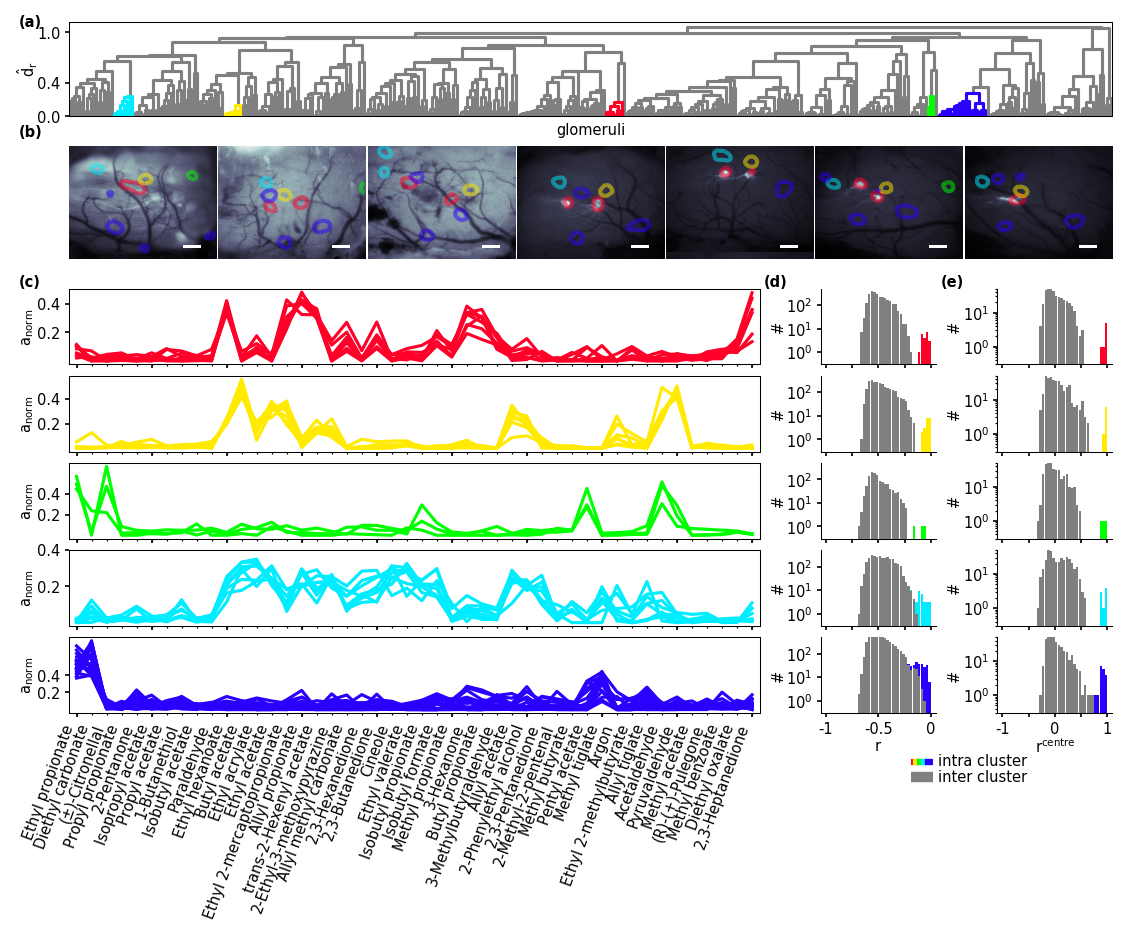

In [95]:
cluster = [200, 172, 256, 254, 278]
num_cluster = len(cluster)

fig = plt.figure(figsize=fig_dim) #(15,1*(num_cluster+2)))
gs_meta = matplotlib.gridspec.GridSpec(3, 1, bottom=0.5, top = 0.99, left = 0.05, right=0.98, 
                                       height_ratios=[1, 1.5, 0.9*num_cluster], hspace=0.07)
axlegend = fig.add_axes([0.8, 0.45, 0.02, 0.02])

metric = 'correlation'
num_animals = len(animals)
num_stim = len(ts.label_stimuli)
clust_colors = {clust: plt.cm.gist_rainbow(1.*cluster.index(clust)/num_cluster) for clust in cluster}

# plot dendrogram
ax = fig.add_subplot(gs_meta[0])
top = gs_meta[0].get_position(fig).corners()[1,1]
fig.text(0.005, top, '(a)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
d = dendrogram(link, link_color_func = color_clusters(cluster, clust_colors), count_sort='descending')
ax.set_xticks([])
ax.set_yticks([0,0.4,1])
ax.set_ylabel('$\hat{d}_{r}$', labelpad=-1)
ax.set_xlabel('glomeruli', labelpad=3)

# plot locations
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, num_animals, gs_meta[1], wspace=0.01)
top = gs_meta[1].get_position(fig).corners()[1,1]
fig.text(0.005, top, '(b)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
axbase = {animal: fig.add_subplot(gs[0,ix]) for ix, animal in enumerate(animals)}
plot_location(ts_normed, link, cluster, bg_dict, axbase, clust_colors, face=False)
#plot_location(ts_normed, link, [cluster[0]], bg_dict, axbase, clust_colors)


# prepare axes for plotting spectra and cluster distances
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(num_cluster, 3, gs_meta[2], hspace=0.15, 
                                                 width_ratios=[6,1,1], wspace=0.2)
# create panel labels
top = gs_meta[2].get_position(fig).corners()[1,1]
fig.text(0.005, top+0.005, '(c)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
left = gs[1].get_position(fig).corners()[1,0]
fig.text(left-0.03, top+0.005, '(d)', fontweight='bold', fontsize=global_fs, ha='right', va='center')
left = gs[2].get_position(fig).corners()[1,0]
fig.text(left-0.03, top+0.005, '(e)', fontweight='bold', fontsize=global_fs, ha='right', va='center')


# plot spectra
axtime = OrderedDict([(clust,fig.add_subplot(gs[ix,0])) for ix, clust in enumerate(cluster)])
plot_spec(ts_normed, link, cluster, axtime, clust_colors)
for ax in axtime.values():
    ax.set_yticks([0.2,0.4])
    ax.set_ylabel('$a_{norm}$', labelpad=0.5)
    ax.set_xticklabels([])
    ax.set_xticks(np.arange(num_stim), minor=True)
    ax.set_xticks(np.arange(0,num_stim, 5))
axtime.values()[-1].set_xticklabels([cas2name[i].decode('utf-8') for i in ts.label_stimuli], 
                                        rotation='70', ha='right', minor=True)

# plot cluster seperation histogramms
for ix, clust in enumerate(cluster):
    cor_inter, cor_intra = inter_intra_dist(ts_normed, link, clust, metric=metric)
    ax1 = fig.add_subplot(gs[ix,1])
    h = ax1.hist([1-cor_inter, [1-cor_intra]], np.linspace(-1,1,41), color=['0.5', clust_colors[clust]], 
            log=True, histtype='barstacked', lw=0, rwidth=0.9, label=['inter', 'intra'])
    ax1.set_ylim((0.3,500))
    ax1.set_yticks([1,10,100])
    ax1.set_ylabel('#', labelpad=0.2)
    ax1.set_xticks([-1,-0.5,0,0.5,1])
    ax1.set_xticklabels([])
    [ax1.spines[i].set_color('none') for i in ['top', 'right']]
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    
    cor_inter, cor_intra = inter_intra_prototypedist(ts_normed, link, clust, metric=metric)
    ax2 = fig.add_subplot(gs[ix,2])
    ax2.hist([1-cor_inter, 1-cor_intra], np.linspace(-1,1,41), color=['0.5',clust_colors[clust]],
            log=True, histtype='barstacked', lw=0, rwidth=0.9)
    ax2.set_ylim((0.3,50))
    ax2.set_yticks([1,10])
    ax2.set_ylabel('#', labelpad=0.2)
    ax2.set_xticks([-1,-0.5,0,0.5,1])
    ax2.set_xticklabels([])
    [ax2.spines[i].set_color('none') for i in ['top', 'right']]
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')

ax1.set_xticks([-1,0,1])
ax1.set_xticklabels([-1, -0.5,0,0.5,1])
ax1.set_xlabel('$r$',labelpad=1)
ax2.set_xticks([-1, -0.5,0,0.5,1])
ax2.set_xticklabels([-1, '', 0, '' ,1])
ax2.set_xlabel('$r^{centre}$', labelpad=0.3)

axlegend.set_axis_off()
[axlegend.plot([i,i+1], [0.05,0.05], color = clust_colors[c], lw=3) for i,c in enumerate(cluster)] 
axlegend.plot([0,len(cluster)], [0,0], color = '0.5', lw=5)
axlegend.text(len(cluster)+1.5, 0.05, 'intra cluster', fontsize=global_fs, va='center')
axlegend.text(len(cluster)+1.5, 0, 'inter cluster', fontsize=global_fs, va='center')
axlegend.set_ylim((-0.02,0.07))



In [97]:
savename = os.path.join(toplevelpath, 'glomcentric_code', 'results', 'tunotopy.png')
fig.savefig(savename, bbox_inches='tight', dpi=600)


### Fig 5: Tunotopic Neighbours

#### nearest cluster

In [98]:
mor182cor = squareform(pdist(ts_glom._series.T, 'correlation'))[ts_glom.label_objects.index('clust_200')]
order = np.argsort(mor182cor)
for i in order[:20]:
    print ts_glom.label_objects[i], mor182cor[i]

clust_200 0.0
clust_264 0.583623412583
clust_183 0.659903300175
clust_281 0.678874965278
clust_228 0.693626345935
clust_220 0.711990341832
clust_247 0.729448383906
clust_319 0.781269922738
clust_146 0.8031235461
clust_257 0.806887392946
clust_292 0.810388760867
clust_254 0.813366183694
clust_343 0.856168266839
clust_145 0.869663425966
clust_362 0.902150224476
clust_303 0.926649893754
clust_172 0.951839129063
clust_276 0.993166280473
clust_187 1.00815501039
clust_299 1.01430228564


#### plot

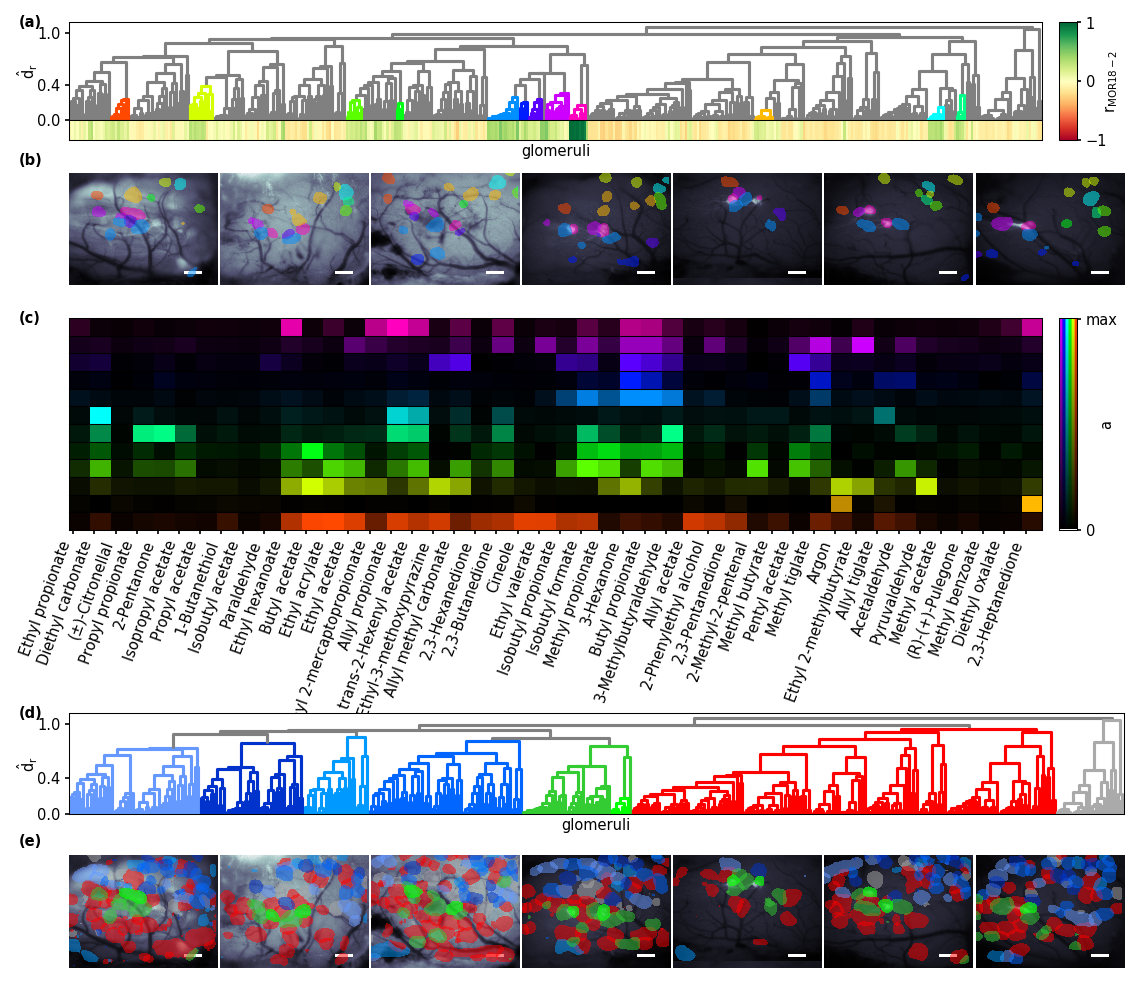

In [99]:
cluster = [200, 292, 257, 228, 264, 183, 281, 220, 247, 319, 146, 254]
num_cluster = len(cluster)

fig = plt.figure(figsize=fig_dim)
gs_meta = matplotlib.gridspec.GridSpec(3, 1, bottom=0.63, top = 0.99, left = 0.05, right=0.99, 
                                       height_ratios=[1,1.4,num_cluster*0.15], hspace=0.04)

num_animals = len(animals)
num_stim = len(ts.label_stimuli)
clust_colors = {clust: plt.cm.gist_rainbow_r(1.*cluster.index(clust)/num_cluster) for clust in cluster}

gs_top = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 3, gs_meta[0], hspace=0.01, height_ratios=[5,1], 
                                                     wspace=0.05, width_ratios=[16.5,0.3,0.5])

# plot dendrogarm
ax = fig.add_subplot(gs_top[0,0])
top = gs_meta[0].get_position(fig).corners()[1,1]
fig.text(0.005, top, '(a)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
d = dendrogram(link, link_color_func = color_clusters(cluster, clust_colors), count_sort='descending')
ax.set_xticks([])
ax.set_yticks([0,0.4,1])
ax.set_ylabel('$\hat{d}_{r}$', labelpad=-1)

# plot MOR18-2 correlation
ax = fig.add_subplot(gs_top[1,0])
im = ax.imshow((1-cor[d['leaves']]).reshape((1,-1)), cmap= plt.cm.RdYlGn, interpolation='none', 
               aspect='auto', vmin=-1, vmax=1)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel('glomeruli', labelpad=2)
# colorbar
axbar = fig.add_subplot(gs_top[:,1])
cbar = plt.colorbar(im, cax=axbar)
cbar.set_ticks([-1,0,1])
cbar.set_label('$r_{MOR18-2}$', labelpad=-2)


# plot locations
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, num_animals, gs_meta[1,:], wspace=0.02)
top = gs_meta[1].get_position(fig).corners()[1,1]
fig.text(0.005, top-0.01, '(b)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
axbase = {animal: fig.add_subplot(gs[0,ix]) for ix, animal in enumerate(animals)}
plot_location(ts_normed, link, cluster, bg_dict, axbase, clust_colors)


# prepare axes for plotting spectra
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(num_cluster, 3, gs_meta[2], hspace=0, wspace=0.05, 
                                                 width_ratios=[16.5,0.3,0.5])
top = gs_meta[2].get_position(fig).corners()[1,1]
fig.text(0.005, top, '(c)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
axtime = OrderedDict([(clust,fig.add_subplot(gs[ix,0])) for ix, clust in enumerate(cluster)])

# plot spectra
plot_spec(ts_normed, link, cluster, axtime, clust_colors, mean_plot_heatmap)
for ax in axtime.values():
    ax.set_xticklabels([])
    ax.set_xticks([])
ax.set_xticks(np.arange(num_stim)-0.3)
ax.set_xticklabels([cas2name[i].decode('utf-8') for i in ts.label_stimuli], 
                                        rotation='70', ha='right')
ax.xaxis.set_tick_params(direction='out', top='off')
# colorbar
cbar = [] 
for i, clust in enumerate(cluster):  

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('tmp', ['0',clust_colors[clust]])
    cbar.append([cmap(i) for i in np.arange(1,0,-0.01)])

axbar = fig.add_subplot(gs[:,1])
axbar.imshow(np.array(cbar).swapaxes(0,1), interpolation='none', aspect='auto')
axbar.set_xticks([])
axbar.set_yticks([0,100])
axbar.set_yticklabels(['max', '0'])
axbar.yaxis.set_ticks_position('right')
axbar.set_ylabel('a', labelpad=-9)
axbar.yaxis.set_label_position('right')




cluster1 = [200, 387, 391, 389, 394, 383, 400, 402][::-1] #2nd level neigbourhood
#cluster2 = [399, 400, 402] #3rd level neighbourhood

# define axes_layout
h_dend = 2 #heigth of dendrogramms
h_base = 2.5 #heigth of spatial plots
h_time = 0.25 #hieght of timeplots


clust_colors = {200:'#00FF00',
                387:'#33CC33',                
                383:'#6699FF',
                391:'#0066FF',
                389:'#0033CC',
                394:'#0099FF',
                400:'#FF0000',
                402:'#AAAAAA'
                }

# plot first level cluster 
gs2 = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[0.6, 1], bottom=0.3, top = 0.5, 
                                        left = 0.05, right=0.99,  hspace=0.1)
fig.text(0.005, 0.5, '(d)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
# plot dendrogram of first cluster
ax = fig.add_subplot(gs2[0])
d = dendrogram(link, link_color_func = color_clusters(cluster1, clust_colors, chex=True), count_sort='descending')
ax.set_xticks([])
ax.set_xlabel('glomeruli', labelpad=2)
ax.set_yticks([0,0.4,1])
ax.set_ylabel('$\hat{d}_{r}$', labelpad=-1)


# plot locations
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, num_animals, gs2[1], wspace=0.02)
top = gs2[1].get_position(fig).corners()[1,1]
fig.text(0.005, top-0.01, '(e)', fontweight='bold', fontsize=global_fs, ha='left', va='center')
axbase = {animal: fig.add_subplot(gs[0,ix]) for ix, animal in enumerate(animals)}
plot_location(ts_normed, link, cluster1, bg_dict, axbase, clust_colors, base_thres=0.1)

In [100]:
savename = os.path.join(toplevelpath, 'glomcentric_code', 'results', 'tunotopy_neighborhood.png')#'/home/jan/Dokumente/Code/MOL2.3paper/MOBPaper/Fig5.pdf'
fig.savefig(savename, bbox_inches='tight', dpi=600)

### Supplemental FigureX

In [20]:
cluster = json.load(open(cluster_file))[title] if load_cluster else None   

In [48]:
fig_dim = (7.48,9.4)
global_fs= 7 

layout = {   'axes.labelsize': 8,
             'axes.linewidth': .75, 
             'xtick.major.size': 2,     # major tick size in points
             'xtick.minor.size': 1,     # minor tick size in points
             'xtick.labelsize': 8,       # fontsize of the tick labels
             'xtick.major.pad': 2,  
             
             'ytick.major.size': 2,      # major tick size in points
             'ytick.minor.size': 1,     # minor tick size in points
             'ytick.labelsize':8,       # fontsize of the tick labels
             'ytick.major.pad': 2,
             
             'mathtext.default' : 'regular',
             'legend.fontsize': 8
             }

import matplotlib as mpl
for k, v in layout.items():
    mpl.rcParams[k] = v 

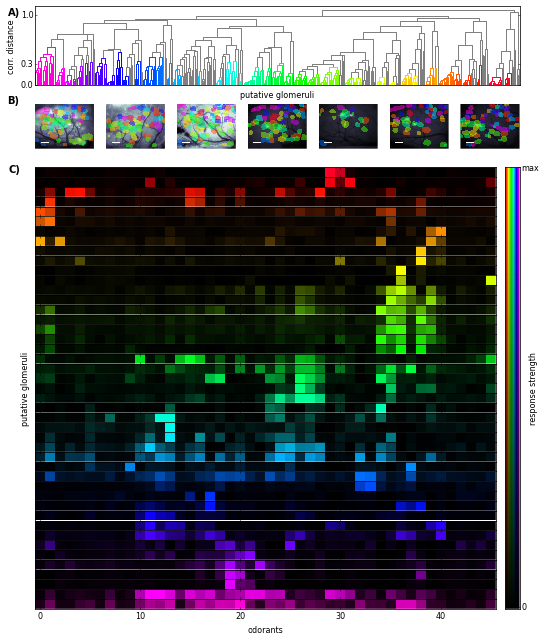

In [93]:
num_cluster = len(cluster)
num_animals = len(animals)
num_stim = len(ts.label_stimuli)
clust_colors = {clust: plt.cm.gist_rainbow(1.*cluster.index(clust)/num_cluster) for clust in cluster}

fig = plt.figure(figsize=fig_dim)
gs_meta = matplotlib.gridspec.GridSpec(3, 1, bottom=0.1, top = 0.99, left = 0.05, right=0.95, height_ratios=[2,2,0.25*num_cluster], hspace=0.01)

# plot dendrogarm
gs_top = matplotlib.gridspec.GridSpecFromSubplotSpec(1,1, gs_meta[0])
ax = fig.add_subplot(gs_top[0])
d = dendrogram(link, link_color_func = color_clusters(cluster, clust_colors), count_sort='descending')
ax.set_xticks([])
ax.set_yticks([0,0.3,1])
ax.set_ylabel('corr. distance')
ax.set_xlabel('putative glomeruli')
ax.text(-225,1,'A)', weight='bold')

# plot locations
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, num_animals, gs_meta[1])
axbase = {animal: fig.add_subplot(gs[0,ix]) for ix, animal in enumerate(animals)}
plot_location(ts_normed, link, cluster, bg_dict, axbase, clust_colors)
axbase[animals[0]].text(-37.5,0,'B)', weight='bold')

# add scalebar
pixel_size = 1.63/1344. *1000. #µm
len_100 = 100.*pixel_size   # 100 µm
for a in animals:
    bg = bg_dict[a]
    bgs = bg.shape
    # extent=[0,84,64,0])
    scalefacx = 84./bgs[0]
    axbase[a].plot((100*scalefacx,(100+len_100)*scalefacx),(55,55),'w')

# prepare axes for plotting spectra
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(num_cluster,2, gs_meta[2], hspace=0, wspace=0.04, width_ratios=[.97, .03])
axtime = OrderedDict([(clust,fig.add_subplot(gs[ix,0])) for ix, clust in enumerate(cluster)])
plot_spec(ts_normed, link, cluster, axtime, clust_colors, mean_plot_heatmap)
axtime[cluster[0]].text(-3.1,0, 'C)', weight='bold')
axtime[cluster[-1]].set_xlabel("odorants")
axtime[cluster[len(cluster)//2]].set_ylabel("putative glomeruli")

# colorbar
cbar = [] 
for i, clust in enumerate(cluster):  

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('tmp', ['0',clust_colors[clust]])
    cbar.append([cmap(i) for i in np.arange(1,0,-0.01)])

axbar = fig.add_subplot(gs[:,1])
axbar.imshow(np.array(cbar).swapaxes(0,1), interpolation='none', aspect='auto')
axbar.set_xticks([])
axbar.set_yticks([-0.5,99])
axbar.set_yticklabels(['max', '0'])
axbar.yaxis.set_ticks_position('right')
axbar.set_ylabel('response strength', labelpad=-9)
axbar.yaxis.set_label_position('right')

In [95]:
savename = os.path.join(toplevelpath, 'glomcentric_code', 'Figures', 'Supp_More_tunotopic_neighbors.png')
fig.savefig(savename, bbox_inches='tight', dpi=600)

### Visualization of other cluster combinations of interest

/Users/micha/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:38: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


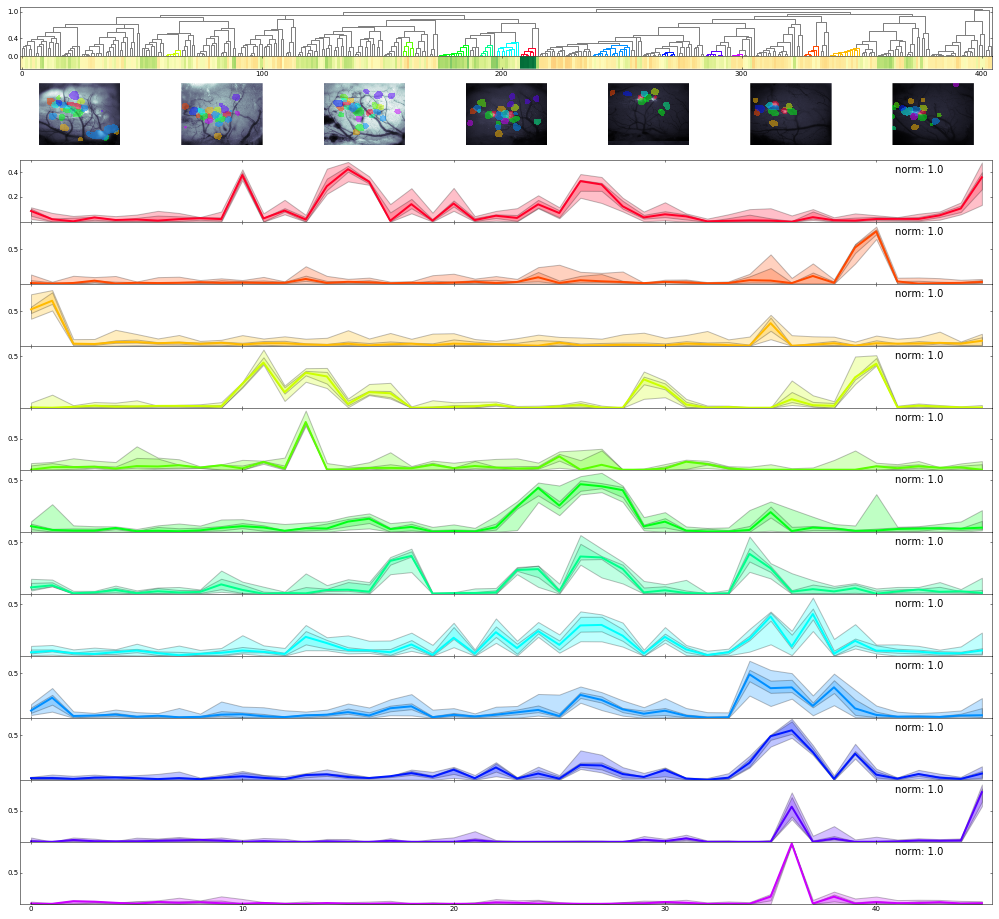

In [27]:
#cluster = [200, 254, 289,204,279,258,220,183,281,257] #all tunotopic close clusters to MOR18-2
#cluster = [200, 163, 247, 254, 197, 319, 281, 362] #good models

cluster = [200,250,211,172,300,264,257,292,261,131,146,62] #all spatial close clusters to MOR18-2

num_cluster = len(cluster)
num_animals = len(animals)
num_stim = len(ts.label_stimuli)
clust_colors = {clust: plt.cm.gist_rainbow(1.*cluster.index(clust)/num_cluster) for clust in cluster}

fig = plt.figure(figsize=(15,1*(num_cluster+2)))
gs_meta = matplotlib.gridspec.GridSpec(3, 1, bottom=0.1, top = 0.99, left = 0.05, right=0.95, height_ratios=[1,1,num_cluster], hspace=0.05)

gs_top = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1, gs_meta[0], hspace=0.01, height_ratios=[4,1])
# plot dendrogarm
ax = fig.add_subplot(gs_top[0])
d = dendrogram(link, link_color_func = color_clusters(cluster, clust_colors), count_sort='descending')
ax.set_xticks([])
ax.set_yticks([0,0.4,1])

# plot MOR18-2 correlation
ax = fig.add_subplot(gs_top[1])
ax.imshow((1-cor[d['leaves']]).reshape((1,-1)), cmap= plt.cm.RdYlGn, interpolation='none', aspect='auto', vmin=-1, vmax=1)
ax.set_yticks([])

# plot locations
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, num_animals, gs_meta[1])
axbase = {animal: fig.add_subplot(gs[0,ix]) for ix, animal in enumerate(animals)}
plot_location(ts_normed, link, cluster, bg_dict, axbase, clust_colors)

# prepare axes for plotting spectra
gs = matplotlib.gridspec.GridSpecFromSubplotSpec(num_cluster,1, gs_meta[2], hspace=0)
axtime = OrderedDict([(clust,fig.add_subplot(gs[ix])) for ix, clust in enumerate(cluster)])
plot_spec(ts_normed, link, cluster, axtime, clust_colors, percentile_plot, norm=np.sqrt(np.sum(ts_normed._series**2, 0)))

savename = os.path.join(toplevelpath, 'glomcentric_code', 'Figures', '_other_cluster_combinations.png')
fig.savefig(savename, bbox_inches='tight', dpi=600)